In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
import experiment as ex
from sk_models import StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
file_name = "mango_684_990.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/mango_cnn") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\mango_cnn\mango_684_990


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


In [4]:
#take our splits on mangoes 
train_ind, val_ind, test_ind = dataset.split_by_col(col = 'Set',train_key="Cal",val_key='Tuning',test_key='Val Ext')
train_ind = np.union1d(train_ind,val_ind)
train_fruit_ids = dataset.meta_data['FruitID'][train_ind].unique()

In [21]:
class IdentityFilter():
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X
    
class SavGolFilter():
    def __init__(self,kernel_size=3,polynomial=2,derivative=0):
        self.kernel_size=kernal_size
        self.polynomial=polynomial
        self.derivative=derivative
        
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = savgol_filter(X,self.kernel_size,self.polynomial,derivative=0)
        return X
    
#standard scaler - sklearn.preprocessing.StandardScaler

class SNVFilter():
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        values = []
        for x in X:
            mean_x = np.mean(x)
            std_x = np.std(x)
            values.append((x-mean_x)/std_x)
        
        values = np.asarray(values)
        return values

class MSCFilter():
    def __init__(self):
        self.mean=None
    def fit(self,X,y=None):
        self.mean = np.mean(X,axis=0)
    def transform(self,X):
        return X

In [6]:
from functools import partial
rmse = partial(mean_squared_error,squared=False)

def mango_cv(model,preprocessing=IdentityFilter(), n_folds=10,loss_function = rmse):
    splitter = KFold(n_splits=n_folds)
    preds = None
    y = None
    for fold, (train_ind_fruit, val_ind_fruit) in enumerate(splitter.split(train_fruit_ids)):
            #split our data
            train_ind_ = dataset.meta_data[dataset.meta_data['FruitID'].isin(train_ind_fruit)].index
            val_ind_  = dataset.meta_data[dataset.meta_data['FruitID'].isin(val_ind_fruit)].index
            train_data_, _, val_data_ = dataset.split(train_ind_, None, val_ind_, preprocessing=None)
            
            #extract our X and y, data from our database
            train_X,train_y = train_data_[:]
            val_X,val_y = val_data_[:]
            
            #apply preprocesing
            preprocessing.fit(train_X)
            train_X = preprocessing.transform(train_X)
            val_X = preprocessing.transform(val_X)
            
            model.fit(train_X,train_y)
            preds_ = model.predict(val_X).reshape(-1).tolist()
            if preds is None:
                preds = preds_
            else:
                preds += preds_
            
            if y is None:
                y = val_y.tolist()
            else:
                y  += val_y.tolist()

    score = loss_function(y,preds)
    return score
            
            
            
            
            #do preprocessing 

In [7]:
def iterate(preprocessing=IdentityFilter()):
    results = {}
    for i in tqdm(range(1,100)):
        model = PLSRegression(n_components = i,scale=False)
        result = mango_cv(model,preprocessing=preprocessing)
        results[i] = result  
    return results

In [8]:
base=iterate()
std= iterate(preprocessing=StandardScaler())

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [22]:
snv = iterate(preprocessing=SNVFilter())

  0%|          | 0/99 [00:00<?, ?it/s]

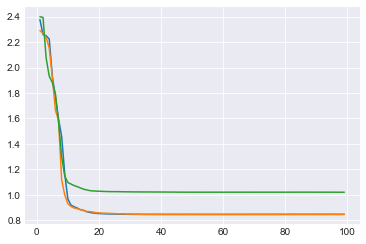

In [23]:
fig, ax = plt.subplots()
ax.plot(base.keys(),base.values(), label='Base') 
ax.plot(std.keys(),std.values(), label='Std')
ax.plot(snv.keys(),snv.values(), label='Std')